In [2]:
import torch
import torch.nn as nn
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import os
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
# model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
# alex_final_only = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
# alex_sudden = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
# alex_descend = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
# alex_gradual = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)

Using cache found in /Users/ciprianbangu/.cache/torch/hub/pytorch_vision_v0.10.0
/opt/homebrew/Caskroom/miniconda/base/envs/neuroai/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/neuroai/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Using cache found in /Users/ciprianbangu/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /Users/ciprianbangu/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /Users/ciprianbangu/.cache/torch/hu

In [4]:
# so the classifier portion has to be changed essentially, i.e., the last nn.Sequential
model.classifier[6] # currently, it is Linear(in:9216, out:4096); Linear(in:4096, out:4096); Linear(in:4096, out:1000)
# we have a 3 class classification problem. 

# so the last layer should be Linear(in:xx, out:3)

Linear(in_features=4096, out_features=1000, bias=True)

In [3]:
# let's give it some options
classifier_sudden = nn.Sequential(
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=9216, out_features=4096), 
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=4096),
    nn.ReLU(inplace=True),
    nn.Linear(in_features=4096, out_features=3)
)

classifier_descend = nn.Sequential(
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=9216, out_features=4096), 
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=2048),
    nn.ReLU(inplace=True),
    nn.Linear(in_features=2048, out_features=3)
)

classifier_gradual_descend_long = nn.Sequential(
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(9216, 4096), 
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=2048),
    nn.ReLU(inplace=True),
    nn.Linear(in_features=2048, out_features=1024),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=1024, out_features=512),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=512, out_features=3)
)

In [18]:
alex_descend

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
alex_final_only.classifier[-1] = nn.Linear(in_features=4096, out_features=3) # works
alex_sudden.classifier = classifier_sudden # works
alex_descend.classifier = classifier_descend # works
alex_gradual.classifier = classifier_gradual_descend_long # works


Now there are different ways to train this thing. I can do the one where the convolutional blocks are totally frozen, or we can unfreeze everything, or we can do small learning rate for the conv blocks

In [4]:
def all_but_last_freeze(model):
    for param in model.features.parameters():
        param.requires_grad = False
    for param in model.classifier[:-1].paramters():
        param.requires_grad = False

def full_feature_freeze(model):
    for param in model.features.parameters():
        param.requires_grad = False

def freeze_most(model):
    for param in model.features[-5:].parameters():
        param.requires_grad = False

In [7]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x[:3, :, :]),  # remove alpha channel
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
input_image = Image.open("/Users/ciprianbangu/Cogmaster/M2 Internship/BCI code/notebooks/data_exploration/scalogram.png")
input_tensor = preprocess(input_image)

Grad cam looks dumb atm but at least it works

In [98]:
import cv2

# Add a batch dimension to the input tensor
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_layers()

    def hook_layers(self):
        def forward_hook(module, input, output):
            self.activations = output

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0]

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate_cam(self, input_tensor, target_class):
        self.model.eval()
        output = self.model(input_tensor)
        self.model.zero_grad()
        target = output[0][target_class]
        target.backward()

        gradients = self.gradients.cpu().data.numpy()[0]
        activations = self.activations.cpu().data.numpy()[0]

        weights = np.mean(gradients, axis=(1, 2))
        cam = np.zeros(activations.shape[1:], dtype=np.float32)

        for i, w in enumerate(weights):
            cam += w * activations[i]

        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (input_tensor.shape[2], input_tensor.shape[3]))
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        return cam

Ok, so grad_cam works, and we know that the parameter freezing we need to do during a training run. So let's see if we can actually do a mini data pipeline here.

I don't think there is any way of getting around saving the scalograms as PNGs because otherwise you wouldn't get the RGB layers, but that is something to think about.

In any case, I have some saved, I think from one subject. Let's see what they look like again.

In [98]:
def plot_scalogram_with_fill(coefs, index, save_dir, label):
    """Plots and saves scalograms for one set of coefficients."""
    fig, axes = plt.subplots(16, 16, figsize=(8, 8))

    # Iterate over channels (coefs has shape (247, 100, 241))
    for ch_idx, channel in enumerate(coefs):                 
        r, c = divmod(ch_idx, 16)
        axes[r, c].pcolormesh(np.abs(channel), cmap='viridis')
        axes[r, c].set_xticks([])
        axes[r, c].set_yticks([])

    # Fill remaining empty subplots with blank images
    for idx in range(coefs.shape[0], 16 * 16):
        r, c = divmod(idx, 16)
        axes[r, c].pcolormesh(np.zeros((50, 241)), cmap='viridis')
        axes[r, c].set_xticks([])
        axes[r, c].set_yticks([])

    # Hide subplot borders
    for ax in axes.flatten():
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)

    plt.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0, wspace=0)
    fig.patch.set_visible(False)

    # Save image
    save_path = os.path.join(save_dir, f"{label}_full_channel_{index}.png")
    plt.savefig(save_path)
    plt.close(fig)  # Close figure to free memory


def plot_average_scalograms(coefs, index, save_dir, label):
    
    fig, axes = plt.subplots(figsize=(8,8))
    
    average = np.mean(np.abs(coefs), axis=0)
    axes.pcolormesh(average)

    axes.set_xticks([])
    axes.set_yticks([])
    axes.spines['top'].set_visible(False)
    axes.spines['right'].set_visible(False)
    axes.spines['left'].set_visible(False)
    axes.spines['bottom'].set_visible(False)

    plt.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0, wspace=0)
    fig.patch.set_visible(False)

    # Save image
    save_path = os.path.join(save_dir, f"{label}_average_channel_{index}.png")
    plt.savefig(save_path)
    plt.close(fig)  # Close figure to free memory


In [ ]:
cwd = os.getcwd()
data_dir = cwd + "/saved_data/"
files = ['a_coefficients_18_2_Feb10.npy', 'e_coefficients_18_2_Feb10.npy', 'i_coefficients_18_2_Feb10.npy']


for file in files:
    coefs = np.load(data_dir + file, mmap_mode='r')
    save_dir = cwd + f"/scalograms_test/images/"
    for i in range(coefs.shape[0]):
            print(f"Processing slice {i+1}/{coefs.shape[0]}")
            plot_scalogram_with_fill(coefs = coefs[i], index = i, save_dir = save_dir, label=file[0])  # Load and process only one slice
    print(f"{file[0]} scalograms completed")

In [100]:
for file in files:
    coefs = np.load(data_dir + file, mmap_mode='r')
    save_dir = cwd + f"/scalograms_test/images_average/"
    for i in range(coefs.shape[0]):
            print(f"Processing slice {i+1}/{coefs.shape[0]}")
            plot_average_scalograms(coefs = coefs[i], index = i, save_dir = save_dir, label=file[0])  # Load and process only one slice
    print(f"{file[0]} scalograms completed")

Processing slice 1/108
Processing slice 2/108
Processing slice 3/108
Processing slice 4/108
Processing slice 5/108
Processing slice 6/108
Processing slice 7/108
Processing slice 8/108
Processing slice 9/108
Processing slice 10/108
Processing slice 11/108
Processing slice 12/108
Processing slice 13/108
Processing slice 14/108
Processing slice 15/108
Processing slice 16/108
Processing slice 17/108
Processing slice 18/108
Processing slice 19/108
Processing slice 20/108
Processing slice 21/108
Processing slice 22/108
Processing slice 23/108
Processing slice 24/108
Processing slice 25/108
Processing slice 26/108
Processing slice 27/108
Processing slice 28/108
Processing slice 29/108
Processing slice 30/108
Processing slice 31/108
Processing slice 32/108
Processing slice 33/108
Processing slice 34/108
Processing slice 35/108
Processing slice 36/108
Processing slice 37/108
Processing slice 38/108
Processing slice 39/108
Processing slice 40/108
Processing slice 41/108
Processing slice 42/108
P

In [ ]:
import csv

# have to make the label CSV
# Get the list of files in the scalograms_test directory
scalogram_files = os.listdir(save_dir)

# Create a CSV file to store the labels
csv_file = os.path.join(save_dir, 'labels.csv')

# Write the file names and labels to the CSV file
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['FileName', 'Label'])  # Write the header

    for file_name in scalogram_files:
        label = file_name.split('_')[0]
        if label == 'a':
            label = 0  # Extract the label from the file name
            writer.writerow([file_name, label])
        elif label == 'e':
            label = 1
            writer.writerow([file_name, label])
        elif label == 'i': 
            label = 2
            writer.writerow([file_name, label])

save_dir = cwd + f"/scalograms_test/images_average/"
# Create a CSV file to store the labels
csv_file = os.path.join(save_dir, 'average_labels.csv')
scalogram_files = os.listdir(save_dir)

# Write the file names and labels to the CSV file
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['FileName', 'Label'])  # Write the header

    for file_name in scalogram_files:
        label = file_name.split('_')[0]
        if label == 'a':
            label = 0  # Extract the label from the file name
            writer.writerow([file_name, label])
        elif label == 'e':
            label = 1
            writer.writerow([file_name, label])
        elif label == 'i': 
            label = 2
            writer.writerow([file_name, label])

In [ ]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import pandas as pd

class AlexNetDataClass(Dataset):
    def __init__(self, csv_file, img_directory, transform=None):
        self.data = pd.read_csv(csv_file)
        self.img_directory = img_directory
        self.transform = transform


    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_directory, str(self.data.iloc[idx, 0]))
        label = int(self.data.iloc[idx, 1])

        image = Image.open(img_path)

        if self.transform:
            image = self.transform(image)

        return image, label

In [31]:
dataset = AlexNetDataClass(csv_file="/Users/ciprianbangu/Cogmaster/M2 Internship/BCI code/scalograms_test/labels.csv", 
                           img_directory="/Users/ciprianbangu/Cogmaster/M2 Internship/BCI code/scalograms_test/images",
                           transform=preprocess)

average_dataset = AlexNetDataClass(csv_file="/Users/ciprianbangu/Cogmaster/M2 Internship/BCI code/scalograms_test/average_labels.csv",
                                   img_directory="/Users/ciprianbangu/Cogmaster/M2 Internship/BCI code/scalograms_test/images_average",
                                   transform=preprocess)

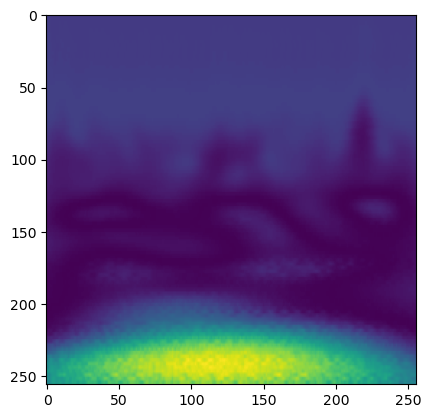

In [ ]:
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
images, labels = next(iter(dataloader))
plt.imshow(images[0,0])

dataloader_average = DataLoader(average_dataset, batch_size=16, shuffle=True)
images, labels = next(iter(dataloader_average))
plt.imshow(images[0,0])

mock training

In [26]:
class AlexNetMPSFinalOnly(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = models.alexnet(weights=True)

        # Keep all layers as they are, including AdaptiveAvgPool2d
        self.features = self.model.features
        self.avgpool = self.model.avgpool  # This is AdaptiveAvgPool2d
        self.classifier = self.model.classifier
        self.classifier[-1] = nn.Linear(in_features=4096, out_features=3)

    def forward(self, x):
        x = self.features(x)  # Feature extraction
        x = self.avgpool(x.to("cpu")).to(x.device)  # Move to CPU, then back to MPS
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Move model to MPS
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
model = AlexNetMPSFinalOnly().to(device)

In [23]:
class AlexNetMPSSuddenDescend(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = models.alexnet(weights=True)

        # Keep all layers as they are, including AdaptiveAvgPool2d
        self.features = self.model.features
        self.avgpool = self.model.avgpool  # This is AdaptiveAvgPool2d
        self.classifier = classifier_sudden

    def forward(self, x):
        x = self.features(x)  # Feature extraction
        x = self.avgpool(x.to("cpu")).to(x.device)  # Move to CPU, then back to MPS
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Move model to MPS
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
model = AlexNetMPSSuddenDescend().to(device)

In [ ]:
class AlexNetMPSLongDescend(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = models.alexnet(weights=True)

        # Keep all layers as they are, including AdaptiveAvgPool2d
        self.features = self.model.features
        self.avgpool = self.model.avgpool  # This is AdaptiveAvgPool2d
        self.classifier = classifier_gradual_descend_long

    def forward(self, x):
        x = self.features(x)  # Feature extraction
        x = self.avgpool(x.to("cpu")).to(x.device)  # Move to CPU, then back to MPS
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Move model to MPS
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
model = AlexNetMPSLongDescend().to(device)

In [66]:
class AlexNetMPSDescend(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = models.alexnet(weights=True)

        # Keep all layers as they are, including AdaptiveAvgPool2d
        self.features = self.model.features
        self.avgpool = self.model.avgpool  # This is AdaptiveAvgPool2d
        self.classifier = classifier_descend

    def forward(self, x):
        x = self.features(x)  # Feature extraction
        x = self.avgpool(x.to("cpu")).to(x.device)  # Move to CPU, then back to MPS
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Move model to MPS
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
model = AlexNetMPSDescend().to(device)

/opt/homebrew/Caskroom/miniconda/base/envs/neuroai/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [67]:
criterion = nn.CrossEntropyLoss()  # For multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

In [ ]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=10): # no validation for now, just want to see if it trains
    model.train()

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)  # Accumulate batch loss
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        epoch_loss = running_loss / total
        epoch_acc = correct / total * 100
        print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

    print("Training complete.")

In [28]:
# all_but_class_freeze(model)
full_feature_freeze(model)

train_model(model, dataloader_average, criterion, optimizer, num_epochs=50)

Epoch [1/50] - Loss: 1.7099, Accuracy: 33.02%
Epoch [2/50] - Loss: 1.2638, Accuracy: 31.17%
Epoch [3/50] - Loss: 1.1497, Accuracy: 36.42%
Epoch [4/50] - Loss: 1.1390, Accuracy: 36.42%
Epoch [5/50] - Loss: 1.0956, Accuracy: 40.43%
Epoch [6/50] - Loss: 0.9985, Accuracy: 53.40%
Epoch [7/50] - Loss: 0.9941, Accuracy: 51.85%
Epoch [8/50] - Loss: 0.9308, Accuracy: 57.10%
Epoch [9/50] - Loss: 0.9808, Accuracy: 57.72%
Epoch [10/50] - Loss: 0.8440, Accuracy: 61.42%
Epoch [11/50] - Loss: 0.8306, Accuracy: 64.81%
Epoch [12/50] - Loss: 0.9120, Accuracy: 58.33%
Epoch [13/50] - Loss: 0.7791, Accuracy: 68.21%
Epoch [14/50] - Loss: 0.6944, Accuracy: 72.22%
Epoch [15/50] - Loss: 0.6677, Accuracy: 72.84%
Epoch [16/50] - Loss: 0.6620, Accuracy: 70.68%
Epoch [17/50] - Loss: 0.6600, Accuracy: 73.77%
Epoch [18/50] - Loss: 0.6334, Accuracy: 72.53%
Epoch [19/50] - Loss: 0.5999, Accuracy: 75.93%
Epoch [20/50] - Loss: 0.5778, Accuracy: 78.09%
Epoch [21/50] - Loss: 0.4904, Accuracy: 81.48%
Epoch [22/50] - Loss: 

KeyboardInterrupt: 

Notes: 

alex last layer + freeze features works pretty well on the averaged data, lr 0.001.

Descend with feature freeze and 0.001 lr learns well on averaged data


I think the big scalogram is just way to big for the resolution of the model. I wonder how they did it in the paper?


In [94]:
def train_val_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    model.train()
    final_val_acc = 0
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)  # Accumulate batch loss
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        epoch_loss = running_loss / total
        epoch_acc = correct / total * 100
        print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for val_images, val_labels in val_loader:
                val_images, val_labels = val_images.to(device), val_labels.to(device)
                val_outputs = model(val_images)
                val_loss += criterion(val_outputs, val_labels).item() * val_images.size(0)
                _, val_predicted = val_outputs.max(1)
                val_total += val_labels.size(0)
                val_correct += val_predicted.eq(val_labels).sum().item()

        val_loss /= val_total
        val_acc = val_correct / val_total * 100
        print(f"Validation - Loss: {val_loss:.4f}, Accuracy: {val_acc:.2f}%")
        final_val_acc = val_acc

        model.train()

    print("Training complete.")
    return final_val_acc

In [74]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

labels = average_dataset.data['Label'].tolist()

train_indices, val_indices = train_test_split(range(len(average_dataset)), test_size=0.1, stratify=labels, random_state=42)

train_dataset = Subset(average_dataset, train_indices)
val_dataset = Subset(average_dataset, val_indices)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [75]:
# Check if any indices are shared between train and validation
overlap = set(train_indices).intersection(set(val_indices))

if overlap:
    print(f"⚠️ WARNING: {len(overlap)} overlapping samples found!")
else:
    print("✅ No contamination detected. Train and validation sets are disjoint.")

✅ No contamination detected. Train and validation sets are disjoint.


In [76]:
train_filenames = set([average_dataset.data.iloc[i, 0] for i in train_indices])
val_filenames = set([average_dataset.data.iloc[i, 0] for i in val_indices])

overlapping_filenames = train_filenames.intersection(val_filenames)

if overlapping_filenames:
    print(f"⚠️ WARNING: {len(overlapping_filenames)} duplicate images found in train & val!")
else:
    print("✅ No image contamination between train and validation sets.")

✅ No image contamination between train and validation sets.


In [77]:
import numpy as np

train_labels = [average_dataset.data.iloc[i, 1] for i in train_indices]
val_labels = [average_dataset.data.iloc[i, 1] for i in val_indices]

# Compute class distributions
unique_labels, train_counts = np.unique(train_labels, return_counts=True)
_, val_counts = np.unique(val_labels, return_counts=True)

print("Train label distribution:", dict(zip(unique_labels, train_counts)))
print("Validation label distribution:", dict(zip(unique_labels, val_counts)))

Train label distribution: {0: 97, 1: 97, 2: 97}
Validation label distribution: {0: 11, 1: 11, 2: 11}


In [ ]:
# model = AlexNetMPSFinalOnly().to(device)
# model = AlexNetMPSDescend().to(device) #by far the best one
# model = AlexNetMPSLongDescend().to(device)
# model = AlexNetMPSSuddenDescend().to(device)
criterion = nn.CrossEntropyLoss()  # For multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer
full_feature_freeze(model)
train_val_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50)

Epoch [1/50] - Loss: 1.0990, Accuracy: 31.27%
Validation - Loss: 1.0986, Accuracy: 33.33%
Epoch [2/50] - Loss: 1.0977, Accuracy: 36.43%
Validation - Loss: 1.0986, Accuracy: 33.33%
Epoch [3/50] - Loss: 1.0756, Accuracy: 37.11%
Validation - Loss: 1.0985, Accuracy: 33.33%
Epoch [4/50] - Loss: 1.0620, Accuracy: 37.80%
Validation - Loss: 1.0793, Accuracy: 36.36%
Epoch [5/50] - Loss: 1.0844, Accuracy: 39.52%
Validation - Loss: 1.0577, Accuracy: 39.39%
Epoch [6/50] - Loss: 1.0627, Accuracy: 37.80%
Validation - Loss: 1.0654, Accuracy: 36.36%
Epoch [7/50] - Loss: 1.0765, Accuracy: 41.58%
Validation - Loss: 1.0841, Accuracy: 39.39%
Epoch [8/50] - Loss: 1.0727, Accuracy: 37.46%
Validation - Loss: 1.0917, Accuracy: 36.36%
Epoch [9/50] - Loss: 1.0741, Accuracy: 35.74%
Validation - Loss: 1.0917, Accuracy: 36.36%
Epoch [10/50] - Loss: 1.0725, Accuracy: 37.80%
Validation - Loss: 1.0775, Accuracy: 36.36%
Epoch [11/50] - Loss: 1.0232, Accuracy: 40.89%
Validation - Loss: 1.0390, Accuracy: 42.42%
Epoch [1

KeyboardInterrupt: 

In [ ]:
from sklearn.model_selection import KFold

def kfold_cross_validation(model_class, dataset, k=5, num_epochs=10):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    fold = 1

    for train_index, val_index in kf.split(dataset):
        print(f"Fold {fold}/{k}")
        
        train_subset = Subset(dataset, train_index.tolist())
        val_subset = Subset(dataset, val_index.tolist())
        
        train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=8, shuffle=False)
        
        model = model_class().to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        
        full_feature_freeze(model)
        train_val_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs)
        
        fold += 1

# Example usage


Fold 1/5


KeyboardInterrupt: 

In [90]:
from sklearn.model_selection import KFold
from torch.utils.data import Subset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim

def full_feature_freeze(model):
    """Freeze only feature extractor layers while keeping classifier trainable."""
    for name, param in model.named_parameters():
        if "classifier" not in name:  # Keep classifier trainable
            param.requires_grad = False
        else:
            param.requires_grad = True  # Allow classifier to train

def kfold_cross_validation(model_class, dataset, k=5, num_epochs=10):
    """Performs K-Fold Cross-Validation and saves the best model."""
    
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    fold = 1
    best_model_weights = None
    best_val_acc = 0.0

    for train_index, val_index in kf.split(dataset):
        print(f"\n🔹 Fold {fold}/{k} 🔹")
        
        train_index, val_index = train_index.tolist(), val_index.tolist()

        # Ensure no overlap (data leakage check)
        train_set, val_set = set(train_index), set(val_index)
        overlap = train_set.intersection(val_set)
        assert len(overlap) == 0, f"⚠️ Data Leakage Detected in Fold {fold}!"

        print(f"✅ No data leakage in Fold {fold} (Train: {len(train_index)}, Val: {len(val_index)})")

        # Create dataset subsets
        train_subset = Subset(dataset, train_index)
        val_subset = Subset(dataset, val_index)

        # Create DataLoaders
        train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=8, shuffle=False)

        # Initialize new model for each fold
        model = model_class().to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        # Freeze feature extractor but keep classifier trainable
        full_feature_freeze(model)

        # Train and validate the model
        val_acc = train_val_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs)

        # 🔹 Save the best model based on validation accuracy
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_weights = model.state_dict()  # Save model state
            print(f"✅ Best model updated (Fold {fold}, Val Acc: {best_val_acc:.2f}%)")

        fold += 1

    print("\n✅ Cross-validation complete!")

    # 🔹 Save the best model
    torch.save(best_model_weights, "best_model.pth")
    print(f"🎯 Best model saved with Val Acc: {best_val_acc:.2f}%")

    # Return the best model
    best_model = model_class().to(device)  # Create a new model
    best_model.load_state_dict(best_model_weights)  # Load best weights
    return best_model

In [95]:
trained_model = kfold_cross_validation(AlexNetMPSDescend, average_dataset, k=5, num_epochs=10)


🔹 Fold 1/5 🔹
✅ No data leakage in Fold 1 (Train: 259, Val: 65)


/opt/homebrew/Caskroom/miniconda/base/envs/neuroai/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10] - Loss: 0.2565, Accuracy: 94.59%
Validation - Loss: 0.0000, Accuracy: 100.00%
Epoch [2/10] - Loss: 0.2091, Accuracy: 96.53%
Validation - Loss: 0.0032, Accuracy: 100.00%
Epoch [3/10] - Loss: 0.1629, Accuracy: 95.75%
Validation - Loss: 0.0026, Accuracy: 100.00%
Epoch [4/10] - Loss: 0.1111, Accuracy: 96.14%
Validation - Loss: 0.0039, Accuracy: 100.00%
Epoch [5/10] - Loss: 0.1357, Accuracy: 96.14%
Validation - Loss: 0.0011, Accuracy: 100.00%
Epoch [6/10] - Loss: 0.1462, Accuracy: 96.53%
Validation - Loss: 0.0025, Accuracy: 100.00%
Epoch [7/10] - Loss: 0.1069, Accuracy: 96.53%
Validation - Loss: 0.0018, Accuracy: 100.00%
Epoch [8/10] - Loss: 0.3510, Accuracy: 92.66%
Validation - Loss: 0.0115, Accuracy: 100.00%
Epoch [9/10] - Loss: 0.2184, Accuracy: 94.59%
Validation - Loss: 0.0135, Accuracy: 100.00%
Epoch [10/10] - Loss: 0.2738, Accuracy: 92.66%
Validation - Loss: 0.0183, Accuracy: 100.00%
Training complete.
✅ Best model updated (Fold 1, Val Acc: 100.00%)

🔹 Fold 2/5 🔹
✅ No dat

tensor([[ -3.0414, -21.5060, -20.4484]], device='mps:0')


/opt/homebrew/Caskroom/miniconda/base/envs/neuroai/lib/python3.12/site-packages/torch/nn/modules/module.py:1805: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


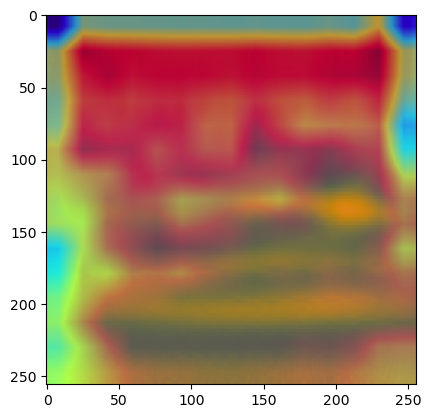

In [100]:
input_image = Image.open("/Users/ciprianbangu/Cogmaster/M2 Internship/BCI code/scalograms_test/images_average/a_average_channel_7.png")
input_tensor = preprocess(input_image)
# Add a batch dimension to the input tensor
input_batch = input_tensor.unsqueeze(dim=0).to(device)

# Ensure the model is in evaluation mode
trained_model.eval()

# Pass the input tensor through the model
with torch.no_grad():
    output = trained_model(input_batch)

print(output)

# Generate Grad-CAM
grad_cam = GradCAM(trained_model, trained_model.features[10])
target_class = output.argmax().item()
cam = grad_cam.generate_cam(input_batch, target_class)

# Convert input image to RGB and visualize the Grad-CAM over the original image
input_image_rgb = input_image.convert("RGB")
input_image_np = np.array(input_image_rgb.resize((input_tensor.shape[1], input_tensor.shape[2])))
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
heatmap = np.float32(heatmap) / 255
overlay = heatmap + np.float32(input_image_np) / 255
overlay = overlay / np.max(overlay)

plt.imshow(overlay)
plt.show()

tensor([[-14.3367,  -4.9464, -13.3994]], device='mps:0')


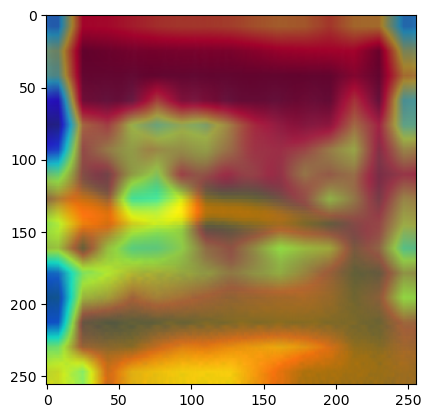

In [101]:
input_image = Image.open("/Users/ciprianbangu/Cogmaster/M2 Internship/BCI code/scalograms_test/images_average/e_average_channel_56.png")
input_tensor = preprocess(input_image)
# Add a batch dimension to the input tensor
input_batch = input_tensor.unsqueeze(dim=0).to(device)

# Ensure the model is in evaluation mode
trained_model.eval()

# Pass the input tensor through the model
with torch.no_grad():
    output = trained_model(input_batch)

print(output)

# Generate Grad-CAM
grad_cam = GradCAM(trained_model, trained_model.features[10])
target_class = output.argmax().item()
cam = grad_cam.generate_cam(input_batch, target_class)

# Convert input image to RGB and visualize the Grad-CAM over the original image
input_image_rgb = input_image.convert("RGB")
input_image_np = np.array(input_image_rgb.resize((input_tensor.shape[1], input_tensor.shape[2])))
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
heatmap = np.float32(heatmap) / 255
overlay = heatmap + np.float32(input_image_np) / 255
overlay = overlay / np.max(overlay)

plt.imshow(overlay)
plt.show()

tensor([[-18.9359, -23.0697,   0.0713]], device='mps:0')


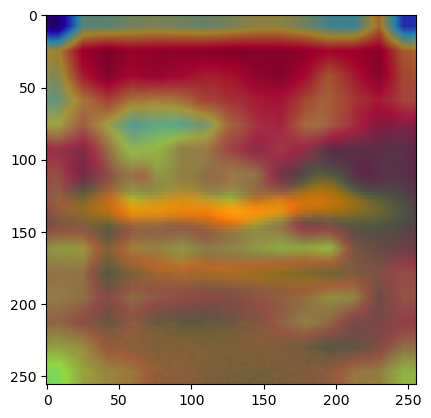

In [103]:
input_image = Image.open("/Users/ciprianbangu/Cogmaster/M2 Internship/BCI code/scalograms_test/images_average/i_average_channel_105.png")
input_tensor = preprocess(input_image)
# Add a batch dimension to the input tensor
input_batch = input_tensor.unsqueeze(dim=0).to(device)

# Ensure the model is in evaluation mode
trained_model.eval()

# Pass the input tensor through the model
with torch.no_grad():
    output = trained_model(input_batch)

print(output)

# Generate Grad-CAM
grad_cam = GradCAM(trained_model, trained_model.features[10])
target_class = output.argmax().item()
cam = grad_cam.generate_cam(input_batch, target_class)

# Convert input image to RGB and visualize the Grad-CAM over the original image
input_image_rgb = input_image.convert("RGB")
input_image_np = np.array(input_image_rgb.resize((input_tensor.shape[1], input_tensor.shape[2])))
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
heatmap = np.float32(heatmap) / 255
overlay = heatmap + np.float32(input_image_np) / 255
overlay = overlay / np.max(overlay)

plt.imshow(overlay)
plt.show()